# Part 1 Preprocess
* * *

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

### Loading the datasets

Create a list of all files and add the corresponding city names and day type

In [3]:
data = [ 
    ("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekdays.csv", "Amsterdam", "Weekdays"),
      #           ("/Users/lauraforerocamacho/Downloads/data/amsterdam_weekends.csv", "Amsterdam", "Weekends"),
]

Merg data from all csv into one data frame 

In [4]:
dfs = []
for file_path, city_name, day_type in data:
    df = pd.read_csv(file_path, usecols=lambda col: col != 'Unnamed: 0')
    df = df.assign(city=city_name, type=day_type)
    dfs.append(df)
data = pd.concat(dfs)

The length and number of columns of the formed dataset

### Basic Inspection of the dataset

Get descriptive information about the dataset

In [5]:
numeric_colums= ["realSum", "person_capacity","cleanliness_rating","guest_satisfaction_overall",'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat']
categorical_colums= ["room_type","room_shared", "room_private", "host_is_superhost","multi", "biz" , 'city', 'type']

In [6]:
for i in categorical_colums:
    data[i] = data[i].astype('object')
    data[i].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

array([False, True], dtype=object)

array([True, False], dtype=object)

array([False, True], dtype=object)

array([1, 0], dtype=object)

array([0, 1], dtype=object)

array(['Amsterdam'], dtype=object)

array(['Weekdays'], dtype=object)

View distributin of the value

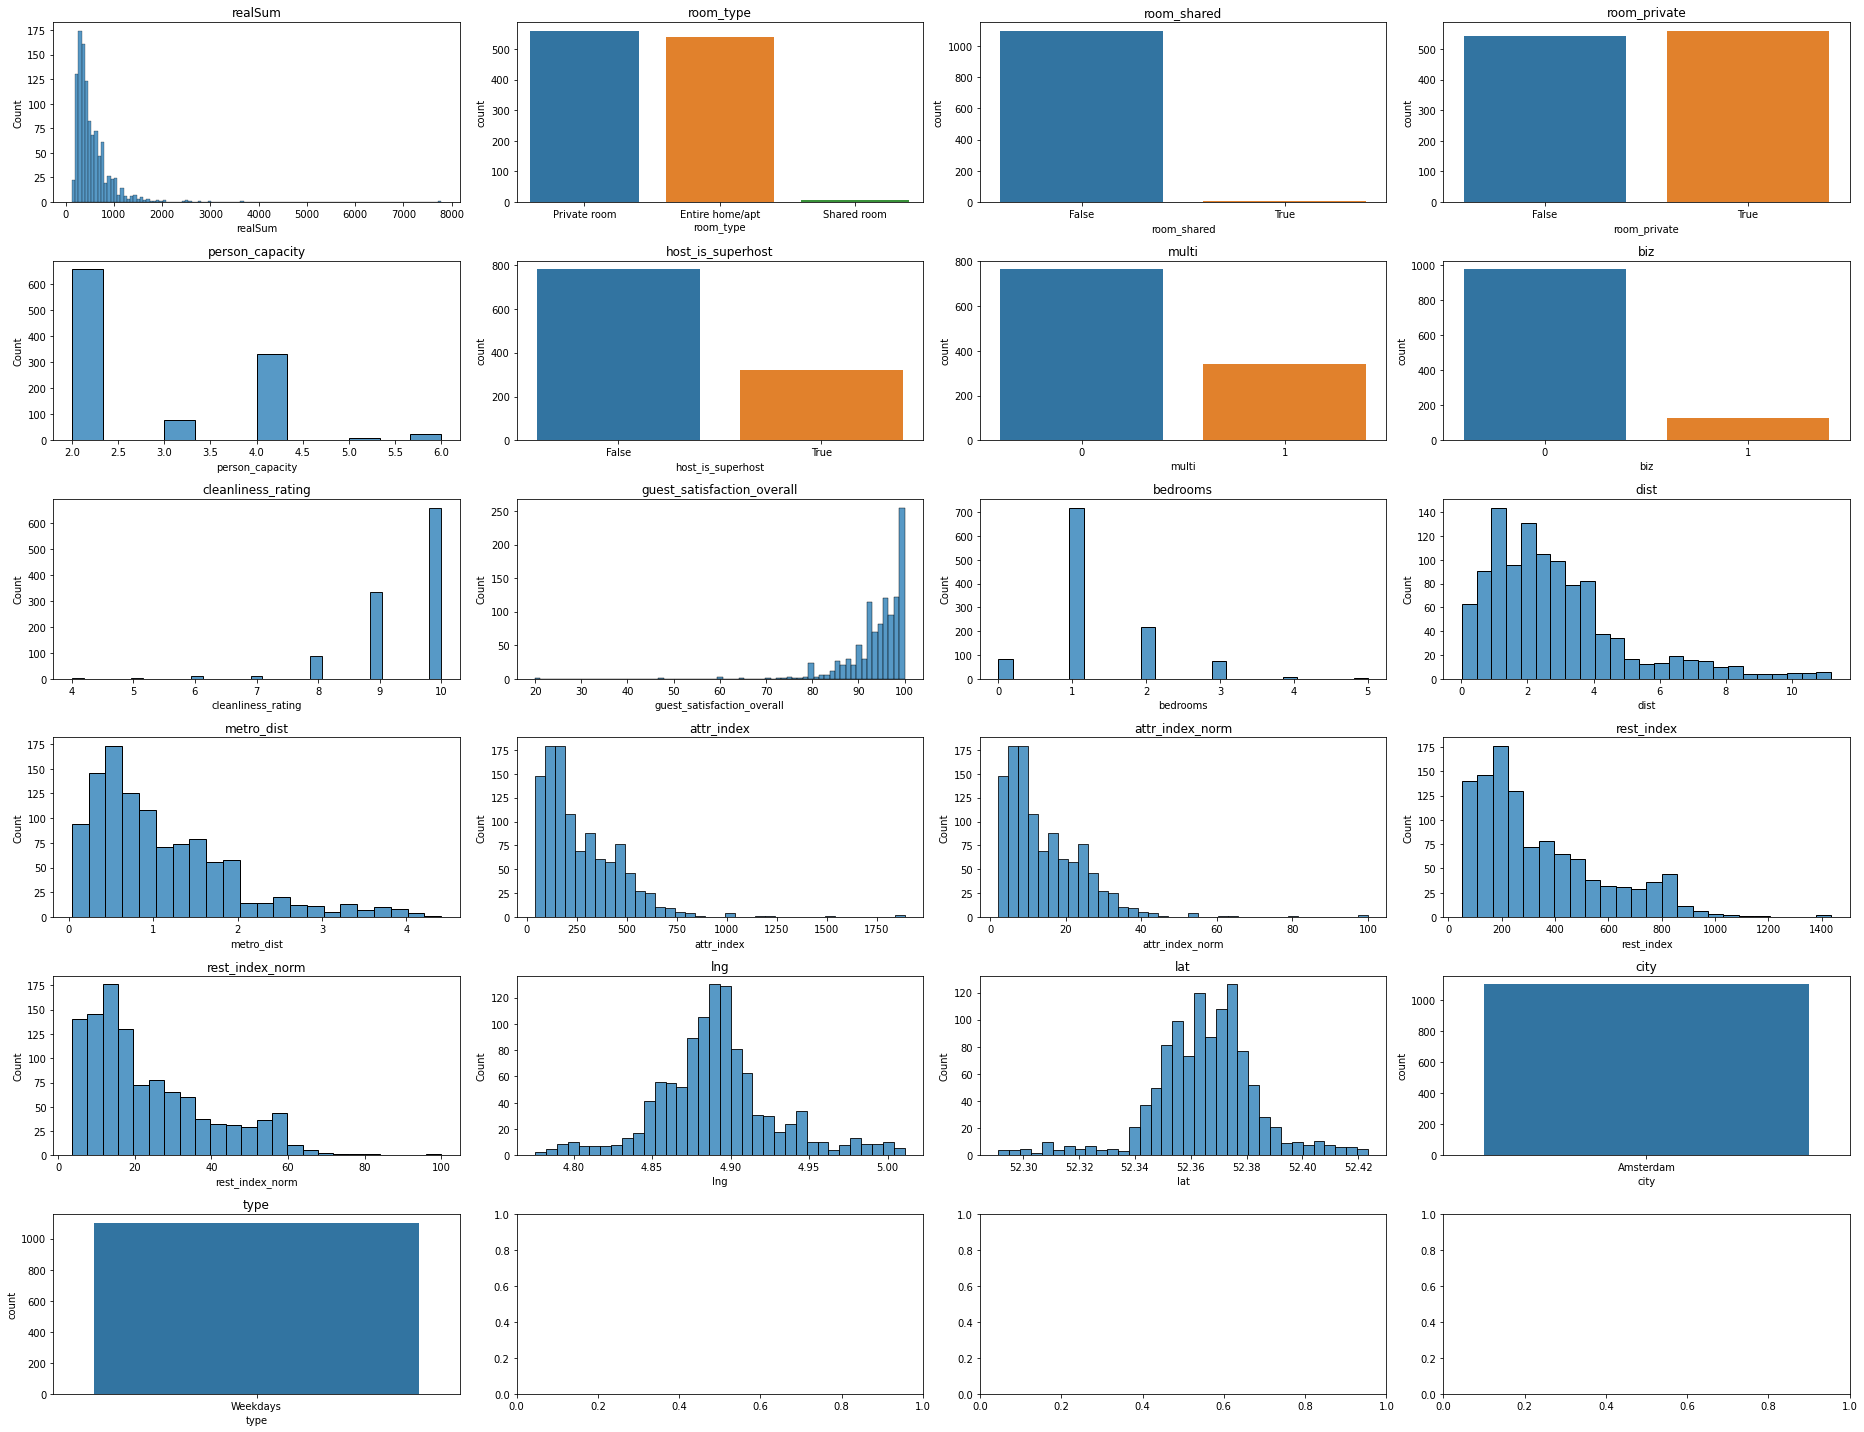

In [7]:
import seaborn as sns


fig, axes = plt.subplots(6,4,figsize=(26,20))

# We will not plot country because it has too many categories.
for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

Latitude and longitude are values that can bring noise to the model.

In [8]:
data_clean=data
#data_clean=data_clean.drop(["lat","lng"], axis=1)

In [9]:
data_clean = data_clean.reset_index()

### Resampling protocol


In [10]:
X = data_clean.loc[:,data_clean.columns != 'realSum']
y = data_clean['realSum']

In [11]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  StandardScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats


In [12]:
numerical_colums=[
 'person_capacity',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'dist',
 'attr_index',
 'rest_index','lat', 'lng']

In [13]:
for i in ["room_shared",	"room_private",	"host_is_superhost"]:
    X[i].replace([False, True],[0,1],inplace=True)

/var/folders/zv/hzjbp8kd1l103x8tgl0s00z80000gn/T/ipykernel_17193/2627953380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i].replace([False, True],[0,1],inplace=True)


In [14]:

for column in ["room_type",  "type"]:
    X_one_hot = pd.get_dummies(X[column] , dtype=int, drop_first=False)
    X = pd.concat([X, X_one_hot], axis='columns')

# drop the values
X= X.drop(["room_type",  "type"], axis='columns')

In [15]:

new_columns=[ 
 'host_is_superhost',          
       'multi',
         'biz',  
         'guest_satisfaction_overall',
         'cleanliness_rating',
       'dist', 
        'metro_dist', 
        'person_capacity',
        'bedrooms',
        'attr_index_norm',
        'rest_index_norm', 
        'Private room',
        'Shared room',
       'room_shared',
         'room_private'
     #,  'lat', 'lng'
 ]
#new_columns=['biz', 'dist', 'person_capacity', 'bedrooms', 'attr_index', 'room_private']
new_columns=['person_capacity', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'rest_index',  'room_shared']
new_columns=[ 
    'host_is_superhost',          
       'multi',
         'biz',  
         'guest_satisfaction_overall',
         'cleanliness_rating',
        'dist', 
        'metro_dist', 
        'person_capacity',
        'bedrooms',
        'attr_index_norm',
        'rest_index_norm', 
       # 'Private room',
       # 'Shared room',
       'room_shared',
         'room_private'
     #   'lat', 'lng'
 ]
X_new= X[new_columns]


In [16]:
numerical_colums_positive= [
'cleanliness_rating',
 'guest_satisfaction_overall',
'person_capacity',
'attr_index_norm',
'rest_index_norm' 
        ,'metro_dist'
 ]

<AxesSubplot:>

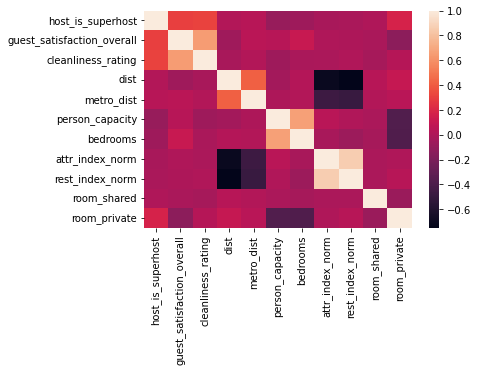

In [17]:
sns.heatmap(X_new.corr(numeric_only=True))
plt.show()

In [18]:
from sklearn.preprocessing import FunctionTransformer


def categorical_preprocessing(X, y,scaler=None):
    print('Original shape:{}'.format(X.shape))
    # Scale numerical variables
    if scaler is None:
        # We only want the scaler to fit the train data
         scaler =  FunctionTransformer(np.log1p, validate=True)
         X[numerical_colums_positive] = scaler.fit_transform(X[numerical_colums_positive])
    else: 
         X[numerical_colums_positive] =  scaler.fit_transform(X[numerical_colums_positive])
    
    # Apply one hot encoding to categorical variables
    print('New shape:{}'.format(X.shape))
    return X, y, scaler

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, random_state=42
 ,stratify=X_new[['room_shared',  'room_private']]
     )
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

Original shape:(772, 13)
New shape:(772, 13)
Original shape:(331, 13)
New shape:(331, 13)


In [19]:
from sklearn.feature_selection import SelectKBest, f_regression

#Selecting the Best important features according to Logistic Regression
sfs_selector = SelectKBest(score_func=f_regression, k=2)
sfs_selector.fit(X_train,y_train)
selected_feature_names = X.columns[sfs_selector.get_support(indices=True)]
feature_scores = zip(selected_feature_names, sfs_selector.scores_[sfs_selector.get_support(indices=True)])
for feature, score in feature_scores:
    print(f"{feature}: {score}")
print(" ")
print("', '".join(selected_feature_names))

SelectKBest(k=2, score_func=<function f_regression at 0x129c10430>)

cleanliness_rating: 214.34518207600655
guest_satisfaction_overall: 189.9495300661435
 
cleanliness_rating', 'guest_satisfaction_overall


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight

sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

#lr_one_hot = GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, random_state=0)
model = GradientBoostingRegressor()

# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

Mean squared error using cross-validation:  169316.97995846375
R2 score using cross-validation:  0.09751719813670992


GradientBoostingRegressor()

Mean squared error on test set:  64259.875705320774
R2 score on test set:  0.4434086543292963


In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()


# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

Mean squared error using cross-validation:  130514.42737525306
R2 score using cross-validation:  0.4472084837274105


LinearRegression()

Mean squared error on test set:  39172.20020970726
R2 score on test set:  0.660707286027354


In [22]:
from sklearn import linear_model

model = linear_model.Lasso()


# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

Mean squared error using cross-validation:  130249.06382570225
R2 score using cross-validation:  0.4517795727590469


Lasso()

Mean squared error on test set:  39719.546810995475
R2 score on test set:  0.6559664056877104


In [23]:
from sklearn.neural_network import MLPRegressor


model = MLPRegressor()


# Calculate the mean squared error using cross-validation
mse_scores = -1 * cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean squared error using cross-validation: ", mse_scores.mean())

# Calculate the R2 score using cross-validation
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print("R2 score using cross-validation: ", r2_scores.mean())

# Train the model on the full training set
model.fit(X_train, y_train)

# Predict on the test set and calculate metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("R2 score on test set: ", r2)

/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

Mean squared error using cross-validation:  186093.19453067082


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

R2 score using cross-validation:  0.07265921648753179


/Users/lauraforerocamacho/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

Mean squared error on test set:  97798.39034603695
R2 score on test set:  0.15291249648927807
